In [15]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv(r'D:\Credit-card-approval-predictor\data\ready_data\modelling_data.csv')

In [4]:
df['TARGET'].value_counts()

TARGET
1.0    535253
0.0      1962
Name: count, dtype: int64

In [5]:
sample1 = df[df['TARGET'] == 1]
sample0 = df[df['TARGET'] == 0]

In [6]:
sample0 = sample0.sample(535253, replace=True)

In [7]:
sample0_reset = sample0.reset_index(drop=True)
sample1_reset = sample1.reset_index(drop=True)

In [8]:
df2 = pd.concat([sample0_reset, sample1_reset], axis='rows', ignore_index=True)

In [40]:
pca = PCA(0.9)

In [41]:
df3 = pca.fit_transform(df2)

In [42]:
df3.shape

(1070506, 7)

In [10]:
df2.columns

Index(['FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'CNT_FAM_MEMBERS', 'STATUS',
       'TARGET', 'AGE', 'YR_EMPLOYEED', 'NEW_OCC_COL', 'House / apartment',
       'Municipal apartment', 'Office apartment', 'Rented apartment',
       'With parents'],
      dtype='object')

### Preparing the batches of the dataset

In [13]:
realty_tensor = torch.tensor(df2['FLAG_OWN_REALTY'].values, dtype=torch.float32)
children_tensor = torch.tensor(df2['CNT_CHILDREN'].values, dtype=torch.float32)
income_tensor = torch.tensor(df2['AMT_INCOME_TOTAL'].values, dtype=torch.float32)
income_type_tensor = torch.tensor(df2['NAME_INCOME_TYPE'].values, dtype=torch.float32)
educ_tensor = torch.tensor(df2['NAME_EDUCATION_TYPE'].values, dtype=torch.float32)
fam_mem_tensor = torch.tensor(df2['CNT_FAM_MEMBERS'].values, dtype=torch.float32)
status_tensor = torch.tensor(df2['STATUS'].values, dtype=torch.float32)
age_tensor = torch.tensor(df2['AGE'].values, dtype=torch.float32)
yr_tensor = torch.tensor(df2['YR_EMPLOYEED'].values, dtype=torch.float32)
occ_tensor = torch.tensor(df2['NEW_OCC_COL'].values, dtype=torch.float32)
house_tesnor = torch.tensor(df2['House / apartment'].values, dtype=torch.float32)
municipal_tensor = torch.tensor(df2['Municipal apartment'].values, dtype=torch.float32)
office_tensor = torch.tensor(df2['Office apartment'].values, dtype=torch.float32)
rent_tensor = torch.tensor(df2['Rented apartment'].values, dtype=torch.float32)
parents_tensor = torch.tensor(df2['With parents'].values, dtype=torch.float32)
target_tensor = torch.tensor(df2['TARGET'].values, dtype=torch.float32)

In [43]:
# X = torch.stack([realty_tensor, children_tensor, income_tensor, income_type_tensor, educ_tensor, fam_mem_tensor, status_tensor, age_tensor, yr_tensor, occ_tensor, house_tesnor, municipal_tensor, office_tensor, rent_tensor, parents_tensor], dim = 1)

Y = target_tensor

In [47]:
X = torch.from_numpy(df3).type(dtype=torch.float32)

In [48]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, test_size=0.2, random_state=42)

In [49]:
train_dataset = TensorDataset(X_TRAIN, Y_TRAIN)
test_dataset = TensorDataset(X_TEST, Y_TEST)

In [50]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [73]:
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Tanh(),
            nn.Linear(in_features=7, out_features=1),
            # nn.Tanh(),
            # nn.Linear(in_features=5, out_features=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)

In [74]:
torch.manual_seed(42)
Model6 = ModelV2()

In [75]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = Model6.parameters(),
                            lr = 0.1)

In [76]:
torch.manual_seed(42)

epochs = 10

for epoch in range(epochs):

    for batch_idx, (batch_features, batch_labels) in enumerate(train_dataloader):

        Model6.train()

        y_logits = Model6(batch_features).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_pred, batch_labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    for batch_idx, (test_features, test_labels) in enumerate(test_dataloader):
        Model6.eval()
        with torch.inference_mode():
            test_logits = Model6(test_features).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_pred, test_labels)



    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")




Epoch: 0 | Loss: 0.68924 | Test Loss: 0.69594
Epoch: 1 | Loss: 0.82723 | Test Loss: 0.69594
Epoch: 2 | Loss: 0.57723 | Test Loss: 0.69594
Epoch: 3 | Loss: 0.70823 | Test Loss: 0.69594
Epoch: 4 | Loss: 0.57723 | Test Loss: 0.69594
Epoch: 5 | Loss: 0.70823 | Test Loss: 0.69594
Epoch: 6 | Loss: 0.60823 | Test Loss: 0.69594
Epoch: 7 | Loss: 0.63924 | Test Loss: 0.69594
Epoch: 8 | Loss: 0.70823 | Test Loss: 0.69594
Epoch: 9 | Loss: 0.67723 | Test Loss: 0.69594


In [32]:
import seaborn as sn


The test loss is tensor(0.6959)
The accuracy score is  0.7727272727272727
The consfusion matrix is


<Axes: >

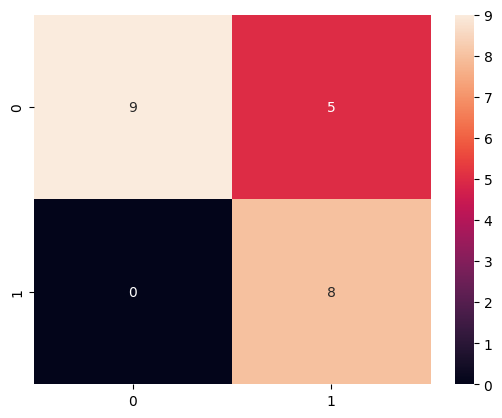

In [77]:
Model6.eval()
all_predictions = []
all_labels = []
with torch.inference_mode():
    for test_features, test_labels in test_dataloader:
        test_logits = Model6(test_features).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_pred, test_labels)

    all_labels.extend(test_labels.tolist())
    all_predictions.extend(test_pred.tolist())
print("The test loss is", test_loss)

print("The accuracy score is ", accuracy_score(y_true=all_labels, y_pred=all_predictions))

cm = confusion_matrix(y_true=all_labels, y_pred=all_predictions)

print('The consfusion matrix is')
sn.heatmap(cm, annot=True, fmt="g")


In [78]:
# saving the model
torch.save(Model6.state_dict(), "D:/Credit-card-approval-predictor/artifacts/model/pytorchneural.pth")

In [81]:
import pickle

with open('D:/Credit-card-approval-predictor/artifacts/pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

In [65]:

print(all_labels)

[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
